In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt

2023-04-26 11:03:59.239312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
key = jax.random.PRNGKey(9)

In [3]:
# fishnets functions

from typing import Sequence, Any
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


def construct_fisher_matrix_single(outputs):
    Q = tfp.math.fill_triangular(outputs)
    middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
    padding = jnp.zeros(Q.shape)

    L = Q - fill_diagonal(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0))) + jnp.eye(n_params)



# custom activation function
@jax.jit
def almost_leaky(x: Array) -> Array:
  r"""Almost Leaky rectified linear unit activation function.
  Computes the element-wise function:
  .. math::
    \mathrm{almost\_leaky}(x) = \begin{cases}
      x, & x \leq -1\\
      - |x|^3/3, & -1 \leq x < 1\\
      3x & x > 1
    \end{cases}
  Args:
    x : input array
  """
  return jnp.where(x < -1, x, jnp.where((x < 1), ((-(jnp.abs(x)**3) / 3) + x*(x+2) + (1/3)), 3*x))




class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.softplus(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


In [4]:
n_params = 2

In [5]:
key = jax.random.PRNGKey(0)

n_outputs = int(n_params + int(n_params * (n_params + 1)) // 2)

theta_fid = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

hidden_size = 128

model = MLP([n_params,hidden_size,hidden_size,hidden_size,n_params])

w = model.init(key, jnp.ones((n_params,)))

outs = model.apply(w, jnp.ones((n_params,)))

In [6]:
# generate some fake data
num = 3000

Σs = np.random.uniform(low=0.1, high=2.5, size=num)
μs = np.random.uniform(low=-1.0, high=1.0, size=num)

θs = jnp.stack([μs, Σs], -1)

def Fisher(θ, n_d=10):
    return jnp.array([[n_d / θ[1], 0.],
                      [0., n_d/(2*θ[1]**2)]])


Fs = jax.vmap(Fisher)(θs)

In [14]:
# learn η(θ; w) function where η is a neural network

@jax.jit
def norm(A):
    return jnp.sqrt(jnp.einsum('ij,ij->', A, A))

def get_α(λ=10., ϵ=0.1):
    return - jnp.log(ϵ * (λ - 1.) + ϵ ** 2. / (1 + ϵ)) / ϵ

    
@jax.jit
def info_loss(w, theta_batched, F_batched):
    λ=10. 
    ϵ=0.001
    α = get_α(λ, ϵ)
    def fn(theta, F):
        #outputs = model.apply(w, theta)
        
        #F /= 18883
        
        mymodel = lambda d: model.apply(w, d)
        
        J_eta = jax.jacrev(mymodel)(theta)
        
        Jeta_inv = jnp.linalg.pinv(J_eta, hermitian=True)
        
        #Jeta_tinv = jnp.linalg.pinv(J_eta.T, hermitian=True)
                
        #Q = Jeta_inv @ Jeta_tinv @ F
        
        Q = Jeta_inv.T @ F @ Jeta_inv
        
        
        loss = norm((Q - jnp.eye(n_params))) + norm((jnp.linalg.pinv(Q) - jnp.eye(n_params)))
        #r =  λ * loss / (loss + jnp.exp(-1.0*α*loss))
        
        # add an off-diagonal term such that Jeta.T Jeta is strongly diagonal
        #offdiag = J_eta.T @ J_eta
        #offdiag -= jnp.diag(offdiag)
        
        #loss += jnp.sum(jnp.abs(offdiag))

        return loss, jnp.linalg.det(Q)
    
    loss,Q = jax.vmap(fn)(theta_batched, F_batched)

    return jnp.mean(loss), jnp.mean(Q)

In [15]:
from tqdm import tqdm
import optax
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(info_loss, has_aux=True)


batch_size = 100
epochs = 500

w = model.init(key, jnp.ones((n_params,)))

losses = jnp.zeros(epochs)

In [16]:
def body_fun(i, inputs):
    w,loss_val, opt_state, detFeta = inputs
    theta_samples = theta_true[i]
    F_samples = F_fishnets[i]

    (loss_val, detFeta), grads = loss_grad_fn(w, theta_samples, F_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)
    
    return w, loss_val, opt_state, detFeta

In [17]:
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)

In [18]:
theta_true = θs.reshape(-1, batch_size, n_params)
F_fishnets = Fs.reshape(-1, batch_size, n_params, n_params)

In [19]:
info_loss(w, theta_true[0], F_fishnets[0])

2023-04-26 11:04:48.060780: W external/xla/xla/service/gpu/ir_emitter_triton.cc:761] Shared memory size limit exceeded.


(Array(121099.07, dtype=float32), Array(3.5258434e+10, dtype=float32))

In [20]:
from tqdm import tqdm
#from tqdm.notebook import trange
batch_size = 100
epochs = 5500



key = jax.random.PRNGKey(99)

losses = jnp.zeros(epochs)
detFetas = jnp.zeros(epochs)

loss_val = 0.
detFeta = 0.

lower = 0
upper = 3000 // batch_size

pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
  key,rng = jax.random.split(key)
  
  # shuffle data every epoch
  randidx = jax.random.shuffle(key, jnp.arange(theta_true.shape[0]))
  F_fishnets = F_fishnets[randidx]
  theta_true = theta_true[randidx]
  
  inits = (w, loss_val, opt_state, detFeta)

  w, loss_val, opt_state, detFeta = jax.lax.fori_loop(lower, upper, body_fun, inits)

  losses = losses.at[j].set(loss_val)
  detFetas = detFetas.at[j].set(detFeta)
  #val_losses.append(val_loss)
  pbar.set_description('epoch loss %d: %.5f, detFeta: %.5f'%(j, loss_val, detFeta))

  0%|          | 0/5500 [00:00<?, ?it/s]/data80/makinen/venvs/fastjax/lib/python3.9/site-packages/jax/_src/random.py:410: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)
2023-04-26 11:04:58.758099: W external/xla/xla/service/gpu/ir_emitter_triton.cc:761] Shared memory size limit exceeded.
epoch loss 0: 3201.65430, detFeta: 17702614.00000:   0%|          | 1/5500 [00:03<6:01:58,  3.95s/it]/data80/makinen/venvs/fastjax/lib/python3.9/site-packages/jax/_src/random.py:410: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)
epoch loss 5499: 0.08674, detFeta: 1.00730: 100%|██████████| 5500/5500 [02:27<00:00, 37.38it/s]      


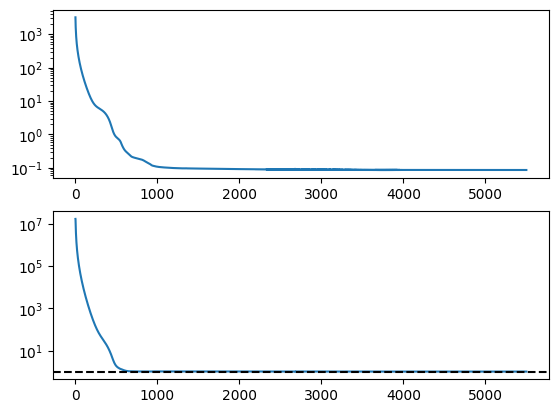

In [21]:
plt.subplot(211)
plt.plot(losses)
plt.yscale("log")

plt.subplot(212)
plt.plot(detFetas)
plt.axhline(1.0, ls='--', color='k')
plt.yscale("log")

In [22]:
# get some predictions over θ

ηs = model.apply(w, θs)

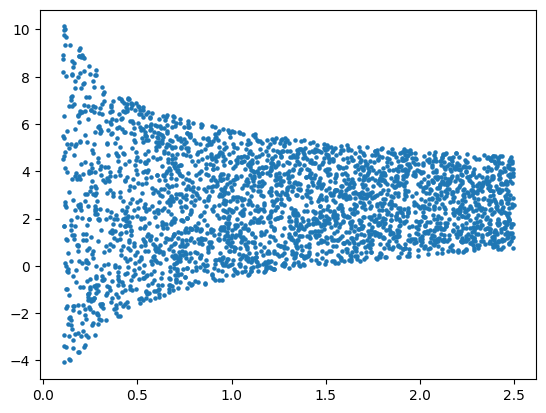

In [23]:
plt.scatter(θs[:, 1], ηs[:, 0], s=5)

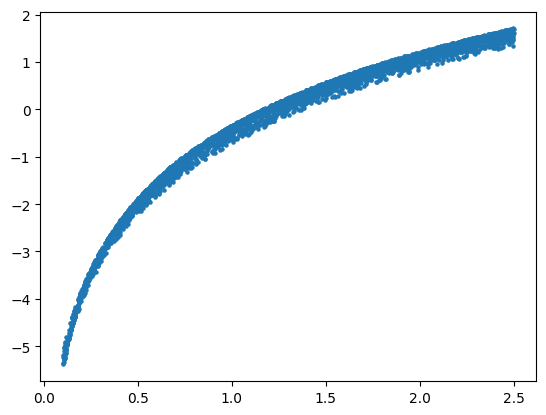

In [24]:
plt.scatter(θs[:, 1], ηs[:, 1], s=5)

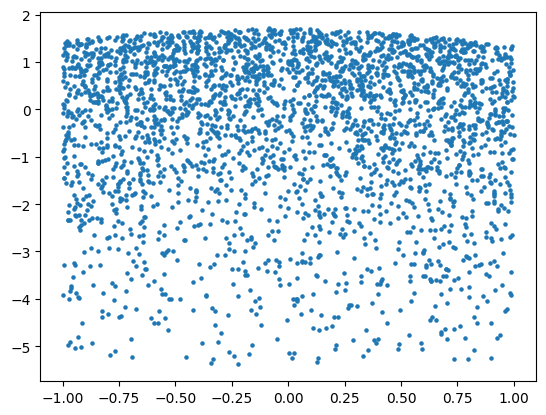

In [25]:
plt.scatter(θs[:, 0], ηs[:, 1], s=5)

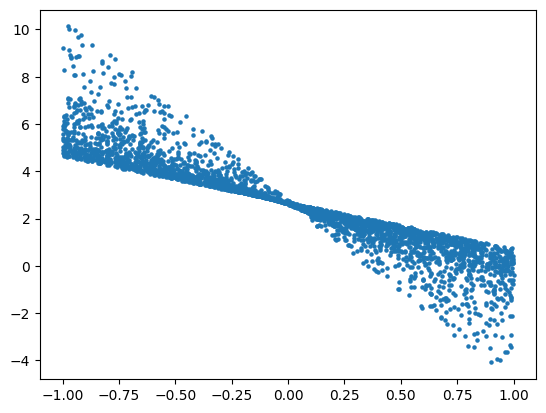

In [26]:
plt.scatter(θs[:, 0], ηs[:, 0], s=5)
#plt.scatter(θs[:, 0], θs[:, 0] )

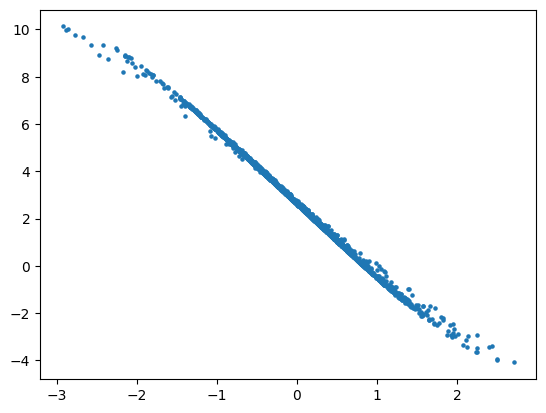

In [27]:
plt.scatter(θs[:, 0] / np.sqrt(θs[:, 1]), ηs[:, 0], s=5)
#plt.plot(θs[:, 0] / np.sqrt(θs[:, 1]), θs[:, 0] / np.sqrt(θs[:, 1]))


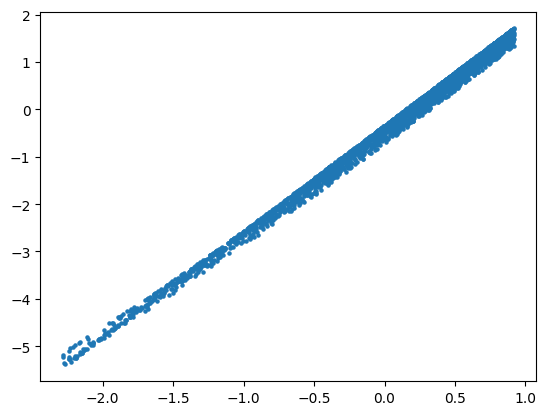

In [35]:
plt.scatter(np.log(θs[:, 1]), ηs[:, 1], s=5)

In [92]:
pwd

'/Users/lucas/repositories/fishnets_for_degenerates'

In [29]:
# generate a lot of data for SR
xs_for_sr = np.random.uniform(low=-1.0, high=1.0, size=10000)
ys_for_sr = np.random.uniform(low=0.1, high=2.5, size=10000)

theta_for_sr =  jnp.stack([xs_for_sr,ys_for_sr], -1)

eta_for_sr = model.apply(w,theta_for_sr)

data_for_sr = jnp.concatenate([theta_for_sr, eta_for_sr], -1)

np.save("data_for_sr", data_for_sr)

In [30]:
# create meshgrid and apply model over it
# Σs = np.random.uniform(low=0.2, high=1.5, size=num)
# μs = np.random.uniform(low=-1.0, high=1.0, size=num)

xs = jnp.linspace(-1.0, 1.0, num=20)
ys = jnp.linspace(0.1, 2.5, num=20)

xs,ys = jnp.meshgrid(xs, ys)

etas = model.apply(w, jnp.stack([xs.flatten(),ys.flatten()], -1))

def true_eta(theta):
    return jnp.stack([theta[..., 0] / jnp.sqrt(theta[..., 1]), jnp.log(theta[..., 1])], -1)


true_etas = true_eta(jnp.stack([xs.flatten(),ys.flatten()], -1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


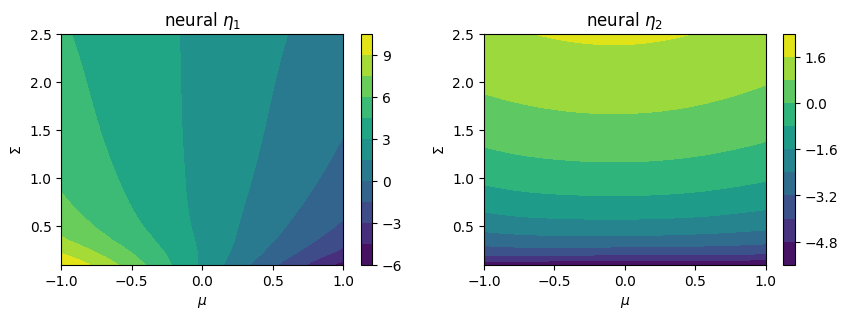

In [31]:
import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

plt.figure(figsize=(10, 3))

plt.subplot(121)

data = etas[:, 0].reshape(xs.shape)

im = plt.contourf(xs, ys, (data), cmap='viridis', levels=10)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'neural $ \eta_1$')
plt.legend(framealpha=0., loc='lower left')

plt.subplot(122)
data = etas[:, 1].reshape(xs.shape)

im = plt.contourf(xs, ys, (data), cmap='viridis', levels=10)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'neural $ \eta_2$')
plt.legend(framealpha=0., loc='lower left')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


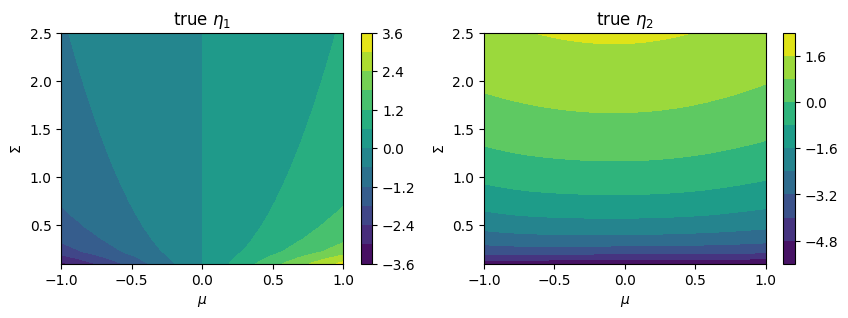

In [32]:
import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

plt.figure(figsize=(10, 3))

plt.subplot(121)

data = true_etas[:, 0].reshape(xs.shape)

im = plt.contourf(xs, ys, (data), cmap='viridis', levels=10)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'true $ \eta_1$')
plt.legend(framealpha=0., loc='lower left')

plt.subplot(122)
data = etas[:, 1].reshape(xs.shape)

im = plt.contourf(xs, ys, (data), cmap='viridis', levels=10)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'true $ \eta_2$')
plt.legend(framealpha=0., loc='lower left')
plt.show()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


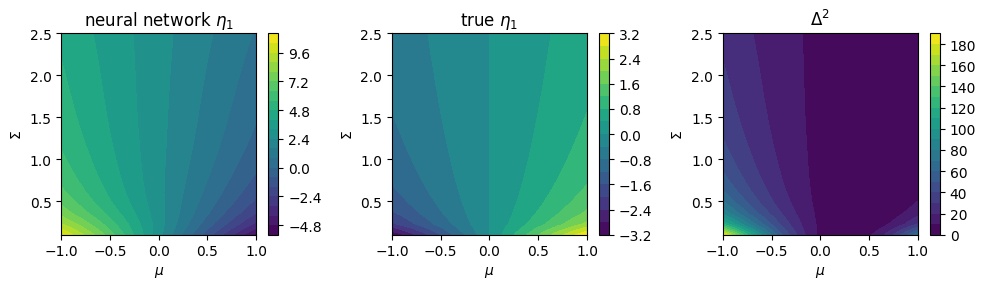

In [33]:
plt.figure(figsize=(10, 3))
data = etas[:, 0].reshape(xs.shape)

plt.subplot(131)
im = plt.contourf(xs, ys, (data), cmap='viridis', levels=20)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'neural network $ \eta_1$')
plt.legend(framealpha=0., loc='lower left')

plt.subplot(132)
data = true_etas[:, 0].reshape(xs.shape)

im = plt.contourf(xs, ys, (data), cmap='viridis', levels=20)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'true $ \eta_1$')


plt.subplot(133)
data = (etas[:, 0].reshape(xs.shape) - true_etas[:, 0].reshape(xs.shape))**2

im = plt.contourf(xs, ys, (data), cmap='viridis', levels=20)
plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'$\Delta^2$')

plt.tight_layout()
plt.show()

In [307]:
# get all the jacobians
rotation_matrix(jnp.array([8])).shape

(2, 2, 1)

In [315]:
# try rotating coordinate space
from jax.scipy.optimize import minimize

def rotation_matrix(angle, dim=2):
    return jnp.squeeze(jnp.array([[jnp.cos(angle), -jnp.sin(angle)], [jnp.sin(angle), jnp.cos(angle)]]))

def get_rotation(angle, args):
    
    A = rotation_matrix(angle)
    jacs = args
    
    def fn(J):
        mat = A @ J
        diag = jnp.diag(mat)
        offdiag = mat - diag # remove diagonal
        return jnp.sum(diag.flatten()) - jnp.sum(offdiag.flatten())
    
    return jnp.sum(jax.vmap(fn)(jacs).flatten())

def rotate_jac(angle, jacs):
    A = rotation_matrix(angle)
    
    def fn(J):
        return A @ J
    return jax.vmap(fn)(jacs)

In [316]:
# get jacobians
mymodel = lambda d: model.apply(w, d)

J_etas = jax.vmap(jax.jacrev(mymodel))(theta_true.reshape(-1, 2))

In [317]:
minimize(get_rotation, x0=jnp.array([0.0]), args=(J_etas,), method='bfgs')

OptimizeResults(x=Array([1.6447912], dtype=float32), success=Array(False, dtype=bool), status=Array(3, dtype=int32, weak_type=True), fun=Array(-22815.451, dtype=float32), jac=Array([-3.885968], dtype=float32), hess_inv=Array([[4.3829954e-05]], dtype=float32), nfev=Array(21, dtype=int32, weak_type=True), njev=Array(21, dtype=int32, weak_type=True), nit=Array(4, dtype=int32, weak_type=True))

In [318]:
J_eta_prime = rotate_jac(1.6447912, J_etas)

In [319]:
J_eta_prime, J_eta

(Array([[[-0.5833891 ,  6.137187  ],
         [ 5.236587  ,  0.07307998]],
 
        [[ 0.616056  ,  1.6477448 ],
         [ 2.829201  ,  0.9000258 ]],
 
        [[-0.7774569 ,  8.383387  ],
         [ 6.0176897 , -0.04741067]],
 
        ...,
 
        [[-0.49824834,  1.6210692 ],
         [ 2.6346586 , -0.19261476]],
 
        [[-1.1099118 ,  3.8917725 ],
         [ 4.004103  , -1.766092  ]],
 
        [[-1.0512117 ,  4.220918  ],
         [ 4.1836476 , -1.8120381 ]]], dtype=float32),
 Array([[[ 5.265386  , -0.38082638],
         [ 0.19466539, -6.125796  ]],
 
        [[ 2.7759159 ,  0.77574944],
         [-0.8235258 , -1.7097726 ]],
 
        [[ 6.0586987 , -0.66704303],
         [ 0.3304572 , -8.356941  ]],
 
        ...,
 
        [[ 2.6642835 , -0.31192917],
         [ 0.30211145, -1.6023939 ]],
 
        [[ 4.0751996 , -2.048968  ],
         [ 0.8108616 , -3.7505605 ]],
 
        [[ 4.249913  , -2.1191213 ],
         [ 0.7390489 , -4.075409  ]]], dtype=float32))

In [324]:
J_eta_prime[0].T @ J_eta_prime[0], J_eta[0].T @ J_eta[0]

(Array([[27.762186 , -3.1976783],
        [-3.1976783, 37.670406 ]], dtype=float32),
 Array([[27.762186 , -3.1976783],
        [-3.1976783, 37.670403 ]], dtype=float32))

# true flat coordinate space
$$ \eta_1 = \frac{\mu}{\sqrt{\Sigma}} $$
$$ \eta_2 = \ln \Sigma $$

## learned up to a rotation matrix
$$  $$ 